In [36]:
from pathlib import Path
from reload_recursive import reload_recursive
import mri_data
import monai_training
import platform
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
reload_recursive(mri_data)
reload_recursive(monai_training)
from mri_data.file_manager import scan_3Tpioneer_bids, DataSet, filter_first_ses  # noqa: E402, F401
import mri_data.file_manager as fm
from mri_data import utils
from monai_training import preprocess  # noqa: E402
from monai_training.preprocess import DataSetProcesser

In [16]:
hostname = platform.node()
if hostname == "rhinocampus":
    drive_root = Path("/media/smbshare")
else:
    drive_root = Path("/mnt/h")

projects_root = Path("/home/srs-9/Projects")
training_work_dirs = drive_root / "training_work_dirs"
msmri_home = projects_root / "ms_mri"

prediction_postfix = "choroid_pineal_pituitary2_pred"
modalities = ["flair", "t1"]

inference_root = drive_root / "3Tpioneer_bids_predictions"
prediction_filename = (
    ".".join(sorted(modalities)) + "_" + prediction_postfix + ".nii.gz"
)
dataroot = drive_root / "3Tpioneer_bids"
work_dir_name = "choroid_pineal_pituitary3"
work_dir = training_work_dirs / work_dir_name
ensemble_out_dir = work_dir / "ensemble_output"

In [15]:
inference_proc = DataSetProcesser.new_dataset(
    inference_root, scan_3Tpioneer_bids, filters=[fm.filter_first_ses],
    label=prediction_filename
)
inference_proc.dataset.sort()
inference_dataset = inference_proc.dataset
inference_dataset = [scan for scan in inference_dataset if scan.label is not None]

In [14]:
inference_dataset[0]

Scan(subid='1001', sesid='20170215', _dataroot=PosixPath('/mnt/h/3Tpioneer_bids_predictions'), _root=PosixPath('/mnt/h/3Tpioneer_bids_predictions/sub-ms1001/ses-20170215'), image=None, label='flair.t1_choroid_pineal_pituitary2_pred.nii.gz', cond=None, id=20190385215)

In [ ]:
labels = ["choroid_t1_flair", "pineal", "pituitary"]
ensemble_out_dataset = scan_3Tpioneer_bids(ensemble_out_dir, label="flair.t1_ensemble.nii.gz")
dataset = DataSet.dataset_like(ensemble_out_dataset)
dataset.dataroot = dataroot
dataset_proc = DataSetProcesser(dataset)
dataset_proc.prepare_labels(["choroid_t1_flair", "pineal", "pituitary"], suffix_list=["CH", "SRS", "ED", "DT"])
dataset = dataset_proc.dataset
dataset.sort()
ensemble_out_dataset.sort()

In [42]:
scan = ensemble_out_dataset[0]
seg = nib.load(scan.label_path).get_fdata()
seg_pineal = seg
seg_pineal[seg!=2] = 0
seg_pineal[seg==2] = 1
pineal_points = np.argwhere(seg_pineal > 0)

In [43]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import ndimage

centroid = ndimage.center_of_mass(seg_pineal)
hull = ConvexHull(pineal_points)

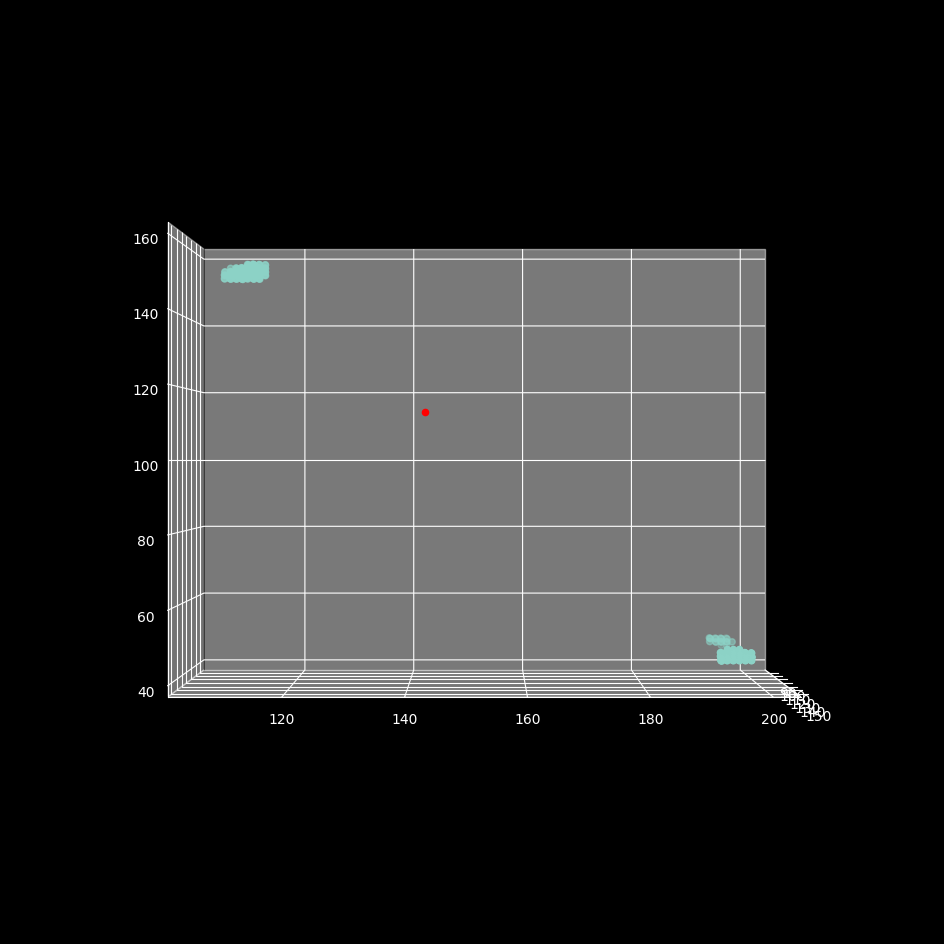

In [48]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pineal_points[:,0], pineal_points[:,1], pineal_points[:,2])
ax.scatter(centroid[0], centroid[1], centroid[2], c='red')
ax.view_init(azim=0, elev=0)

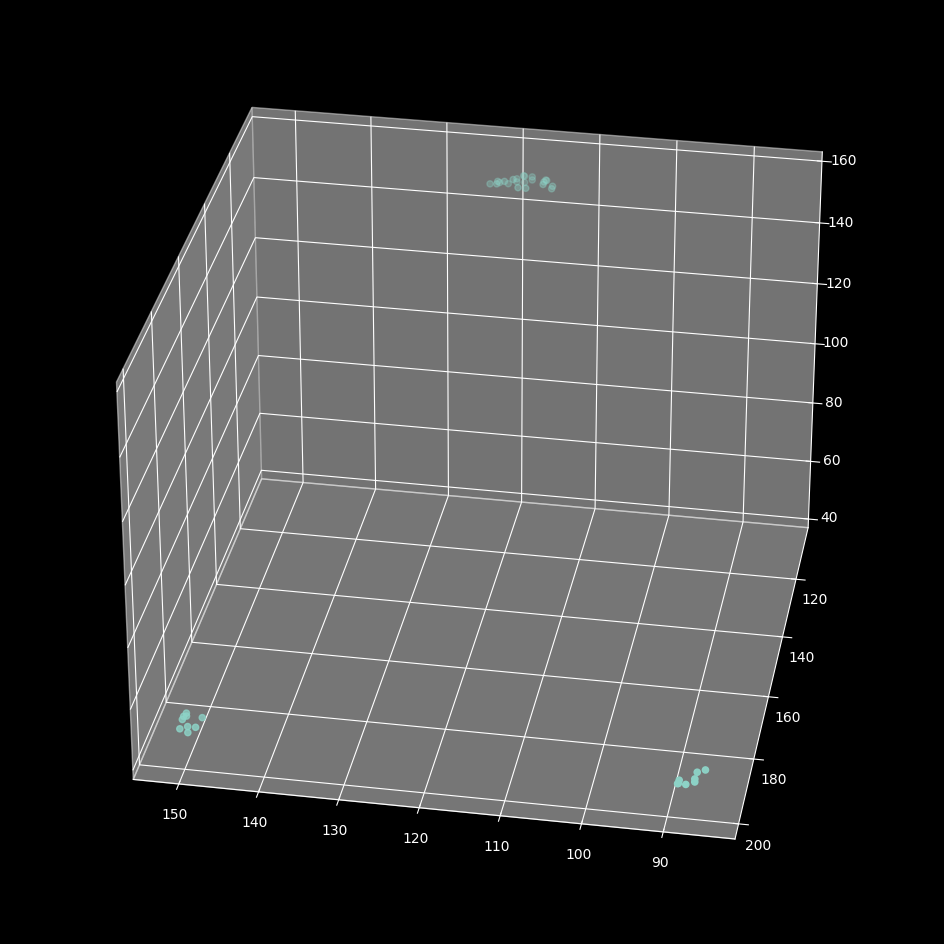

In [55]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], hull.points[hull.vertices, 2])
ax.view_init(azim=100, elev=30)